# Cooking ingredients recommendation
This notebook builds a recommendation system for cooking ingredients using. The end goal is to build a recommendation system that takes as input a list of existing ingredients and outputs a collection of ingredients that would go well with the existing ingredients. 

<b> Notebook contents </b>
0. load and clean data  
1. Preliminary analysis
2. Non-negative matrix factorizations
3. Word-embeddings
4. Association rule mining    
5. Future directions / To Do 

***NOTE:*** *This is project is in progress.*



In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [2]:
import pandas as pd
import numpy as np
import re
import random
import ijson
import ast 
import csv
import statistics
import time
from itertools import combinations


from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from collections import Counter 
 
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')

import os
import pickle
import h5py
import gensim
from gensim.models import Word2Vec
from gensim.models.nmf import Nmf
from gensim.corpora import Dictionary

from efficient_apriori import apriori

# 0. Load & clean data    

* data: <a href="https://www.kaggle.com/kaggle/recipe-ingredients-dataset/">recipe-ingredients dataset</a> from Kaggle. The dataset was part of a competition for predicting the cuisine type given ingredients list. 
* I chose this dataset because I wanted my recommender system to address questions like "How do I cook my chicken in Indian style? Korean style?  
* I used just the training data of this dataset. If one was interested in building a recommender system for ingredients without considering the cuisine, one could use both the training and testing set of the Kaggle dataset. One can also extend the dataset by combining with other sources of recipe data  
* For example, the "recipes" notebook uses a different dataset. Note that that particular dataset requires more involved text cleaning process than the kaggle dataset

<b> Contents </b>  
(a) Cleanup text  
(b) Remove "stop words"  
(c) Create documents that contain both the list of ingredients and cuisine type  

<b> (a) Cleanup text </b>  
* Cleanups performed
    * Remove parentheses and characters between parentheses. This removes quantity information. ex) " (2 oz. ) tomato sauce"
    * Convert all strings into lowercase letters  
    * Replace spaces with underscore _   
 
* Remaining issues with the data after cleanup step
    * Some ingredients contain brand names of the ingredients.  
    * Some ingredients contain non-alphabet characters. Many of them seem to come from brand names.   
    * Some ingredients contain cooking instructions. Example: "spinach, thawed and squeezed dry"  

In [2]:
# load data
file_name = 'data/recipe-ingredients-dataset/train.json'

with open(file_name, 'r') as f:
    objects = ijson.items(f, 'item')
    data = list(objects)

df = pd.DataFrame(data)

In [3]:
# Look at data to figure out what kind of text cleaning we need to do

ing_list = df['ingredients'].tolist()
cuisine_list = df['cuisine'].tolist()

if len(ing_list) == len(cuisine_list):
    ingredients = [ing_list[i] + [cuisine_list[i]] for i in range(len(ing_list))]
else:
    print('error. Length of ingredients and cuisine does not match')

print("Example ingredients")
ing_list = np.unique([item for recipe in ingredients for item in recipe ])
print(ing_list[:20])
print(ing_list[-20:])

Example ingredients
['(    oz.) tomato sauce' '(   oz.) tomato paste'
 '(10 oz.) frozen chopped spinach'
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry'
 '(14 oz.) sweetened condensed milk' '(14.5 oz.) diced tomatoes'
 '(15 oz.) refried beans' '1% low-fat buttermilk'
 '1% low-fat chocolate milk' '1% low-fat cottage cheese' '1% low-fat milk'
 '2 1/2 to 3 lb. chicken, cut into serving pieces'
 '2% low fat cheddar chees' '2% low-fat cottage cheese'
 '2% lowfat greek yogurt' '2% milk shredded mozzarella cheese'
 '2% reduced-fat milk' '25% less sodium chicken broth'
 '33% less sodium cooked deli ham' '33% less sodium cooked ham']
['yolk' 'yoplait' 'young coconut meat' 'young leeks' 'young nettle'
 'yu choy' 'yuca' 'yucca' 'yucca root' 'yukon gold' 'yukon gold potatoes'
 'yuzu' 'yuzu juice' "za'atar" 'zest' 'zesty italian dressing' 'zinfandel'
 'ziti' 'zucchini' 'zucchini blossoms']


In [4]:
# Remove characters between (and including) parentheses
# Turn all strings into lowercase  
# Replace spaces with underscore. 

for i in df.index:
    ing = df.at[i,'ingredients']
    for j, item in enumerate(ing):
        
        # Replace all characters between parentheses
        if  ('(' in item) or (')' in item):
            item = re.sub('\s*\([^)]*\)\s*', '', item)
            ing[j] = item
        
        # Turn all Upper case into lowercase
        ing[j] = item.lower()
        
        # replace spaces with underscore 
        ing[j] = ing[j].replace(' ','_')
        
    df.at[i,'ingredients'] = ing

<b> (b) Remove "stop words" </b> 
* stop words: ingredients that appear frequently throughout the documents.  
* Based on the frequency of ingredients, I removed "salt" from every document.

In [6]:
# get the list of ingredients
ing_list = df['ingredients'].tolist()
ingredients_total = [item for sublist in ing_list for item in sublist]

# count occurrence of ingredients
ing_count = Counter(ingredients_total)

# sort ingredients in order of decreasing frequency 
ing_by_count = [k for k, v in sorted(ing_count.items(), key = lambda item:item[1])]
ing_by_count.reverse()

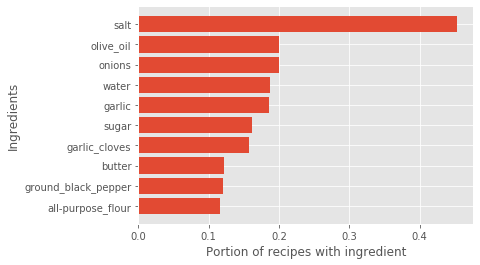

In [7]:
# Visualize top N most frequently used ingredients
N = 10

n_documents = df.shape[0]
frequent_ing = ing_by_count[:N]
prob_ing = [ing_count[item]/n_documents for item in frequent_ing]

plt.barh(frequent_ing[::-1], prob_ing[::-1])
plt.xlabel('Portion of recipes with ingredient')
plt.ylabel('Ingredients')
plt.title('')
plt.show()

The above graph shows that more than 40% of documents contain the ingredient "salt". I decided to remove the ingredient "salt" from all documents.

In [8]:
# Remove the ingredient "salt"
for i in range(df.shape[0]):
    ing = df.at[i,'ingredients']
    df.at[i,'ingredients'] = [item for item in ing if item != 'salt']

<b>(c) Create documents that have both ingredients list and cuisine type </b>

In [9]:
# get list of ingredients and list of cuisine
ing_list = df['ingredients'].tolist()
cuisine_list = df['cuisine'].tolist()

if len(ing_list) == len(cuisine_list):
    ingredients = [ing_list[i] + [cuisine_list[i]] for i in range(len(ing_list))]
else:
    print('error. Length of ingredients and cuisine does not match')    
    
# add cleaned up ingredients + cuisine to dataframe
df['document'] = ingredients

In [10]:
# add cleaned up ingredients + cuisine to dataframe
df['document'] = ingredients
df.to_csv('data/ingredient_recommendation/data.csv')

In [11]:
df.head()

,id,cuisine,ingredients,document
0,10259,greek,"[romaine_lettuce, black_olives, grape_tomatoes...","[romaine_lettuce, black_olives, grape_tomatoes..."
1,25693,southern_us,"[plain_flour, ground_pepper, tomatoes, ground_...","[plain_flour, ground_pepper, tomatoes, ground_..."
2,20130,filipino,"[eggs, pepper, mayonaise, cooking_oil, green_c...","[eggs, pepper, mayonaise, cooking_oil, green_c..."
3,22213,indian,"[water, vegetable_oil, wheat]","[water, vegetable_oil, wheat, indian]"
4,13162,indian,"[black_pepper, shallots, cornflour, cayenne_pe...","[black_pepper, shallots, cornflour, cayenne_pe..."


# 1. Preliminary analysis  

(a) Preliminary analysis. Identify potential bias in dataset    
(b) Split data into training, cross-validation, and testing set  
(c) Define metrics for evaluating different models  

<b> (a) Preliminary analysis </b>  

* About 40,000 documents(recipes) involving 6700 ingredients  
* Note the <b>potential bias</b>
    * Our dataset is biased: Some cuisine (like Italian and Mexican cuisine) are more frequently represented than some others (like Russian and brazilian cuisinze).  
    *  A recommender might recommend ingredients that go well together in mostly Italian and Mexican cuisine. 
    *  <b><font color='red'>To Do</font></b>: I might want to consider some tools for decreasing bias from my model. 

In [12]:
# load data
df = pd.read_csv('data/ingredient_recommendation/data.csv')

# Convert to format (list of lists)
documents = [ast.literal_eval(df.document[idx]) for idx in range(df.shape[0])]

In [14]:
# number of documents and ingredients
ing_list = np.unique([item for recipes in documents for item in recipes])

print('total number of recipes: ', len(ingredients))
print('total number of ingredients: ', len(np.unique(ing_list)))

total number of recipes:  39774
total number of ingredients:  6712


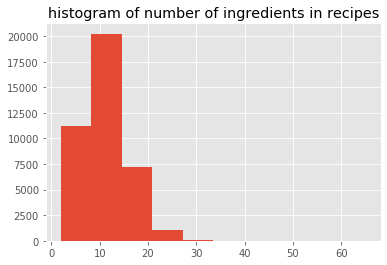

maximum number of ingredients in a given recipe:  65
minimum number of ingredients in a given recipe:  2


In [15]:
# Number of ingredients in each recipe
ing_len = [len(x) for x in ingredients]

plt.hist(ing_len)
plt.title('histogram of number of ingredients in recipes')
plt.show()
print('maximum number of ingredients in a given recipe: ', max(ing_len))  
print('minimum number of ingredients in a given recipe: ', min(ing_len))

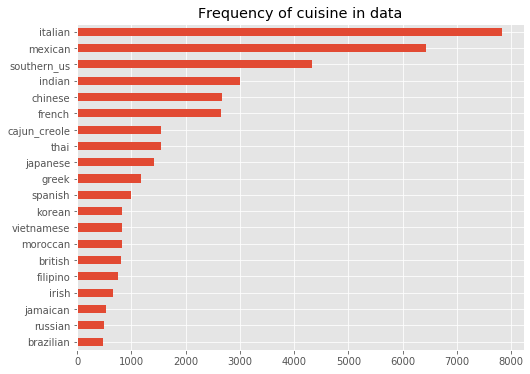

In [16]:
# Number of cuisine represented
df['cuisine'].value_counts(ascending = True).plot(kind = 'barh', figsize=(8,6))
plt.title('Frequency of cuisine in data')
plt.show()

<b> NOTE: POTENTIAL BIAS </b>
* The above graph indicates that our dataset is biased -- Italian and Mexican cuisine are represented much more than other types of cuisine.   
* One should be aware that any model trained on this dataset could potentially be biased.

<b> (B) Divide into training, cross-validation, and testing set </b>

In [17]:
# Divide into training (70%), cross-validation (15%), and testing set (15%)
n_documents = df.shape[0]
print('total number of documents: ', n_documents)

total = list(range(n_documents))
random.shuffle(total)

train_size = int(n_documents * 0.7)
cv_size = int(n_documents * 0.15)
train_idx = total[:train_size]
cv_idx = total[train_size:train_size + cv_size]
test_idx = total[train_size + cv_size:]

print('number of training set: ', len(train_idx))
print('number of cross-validation set: ', len(cv_idx))
print('number of test set: ', len(test_idx))

train_idx.sort()
cv_idx.sort()
test_idx.sort()

# save indices
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'w')
f.create_dataset("train_idx", data = train_idx)
f.create_dataset("cv_idx", data = cv_idx)
f.create_dataset("test_idx", data = test_idx)
f.close()

total number of documents:  39774
number of training set:  27841
number of cross-validation set:  5966
number of test set:  5967


<b> (f) Define metric for evaluating different models</b>  
* In order to compare the performance of multiple models, I decided on a common metric to evaluate the models.  
* Use evaluation metric for classification models      
* Precision, Recall, and F-scores 
    * Precision: Of all the predicted ingredients, how much were actually true ingredients? TP / (TP + FP)
    * Recall: Of all the true ingredients, how much did we predict correctly? TP/(TP + FN)   
    * F-score : (2 * recall * precision) / (recall + precision)    
    
* Possible option: Weigh the incorrect ingredients. For example, if an incorrect predicted ingredient is still considered "similar" to an existing ingredient (maybe using word embedding features), one can still account for the incorrect prediction as a true positive with a smaller weight than 1
  

In [23]:
def sample_ingredients(ing, n_samples):  
    # For each recipe, sample "n_samples" number of ingredients randomly.
    # (If a recipe involves fewer than "n_samples" ingredients, ignore that recipe)
    # The sampled ingredients will function as the existing ingredients
    # Goal of the model is to predict the remaining ingredients that
    # have not been sampled
    
    """
    --- input ---
    ing: (list of lists) Each item of ing is a list of ingredients 
           for a particular recipe
    n_samples: (int) number of ingredients to be sampled
   
    --- output ---
    existing_ing: (list of lists) Each item of sampled_ing is a list of 
            ingredients that have been sampled
    missing_ing: (list of lists) Each item of remaining_ing is a list of ingredients
            that have not been sampled
    """
    
    existing_ing = []
    missing_ing = []
    for recipe in ing:
        if len(recipe) > n_samples:
            # randomly select 5 ingredients
            sampled = random.sample(recipe, n_samples)
            remain = list(set(recipe)-set(sampled))

            existing_ing.append(sampled)
            missing_ing.append(remain)
            
    return existing_ing, missing_ing


In [75]:
def compute_scores(predicted_ing, true_ing):
    """
    predicted_ing: (list) of predicted ingredients from the model
    true_ing: (list) of true ingredients that needed to be predicted
    """
    
    predicted_ing = set(predicted_ing)
    true_ing = set(true_ing)

    TP = len(predicted_ing.intersection(true_ing))

    precision = TP / (len(predicted_ing))
    recall = TP / len(true_ing)
    
    if recall != 0 and precision != 0:
        F_score = (2 * recall * precision)/(precision + recall)
    else:
        F_score = 0
    
    return precision, recall, F_score


In [20]:
# example 
precision, recall, F_score = compute_scores(['onions', 'scallions', 'bread'],
                                           ['scallions'])

print('precision: ' , precision)
print('recall: ', recall)
print('F_score: ', F_score)

precision:  0.3333333333333333
recall:  1.0
F_score:  0.5


# 2. Non-negative matrix factorization


<b> Summary </b> 
* Since we are building a recommender, I first tried collaborative filtering via non-negative matrix factorization. 
* The latent variables (roughly) correspond to type of cuisine, such as baking, Italian food, Mexican food, ... .  
* Non-negative matrix factorization requires the user to specify the number of latent variables (topics). I implemented two different ways of identifying the appropriate number of latent variables:
    * I first selected the number of latent variables by evaluating the recommenders on a cross-validation set. The optimal number of latent variables was 6. 
    * However, this seemed like a very low number, since our dataset clearly contains more than 6 different types of cuisine. 
    * The "optimal" number of latent variables may be very low because of the bias in our dataset. 
    * I then considered NMF as a language model, and used the coherence score to select the number of latent variables.  
    * The coherence score is maximized when we use 20 latent variables.

<b> The idea behind non-negative matrix factorization (NMF) & recommender </b>  
* Let V be a documents-ingredients matrix.
    * Each row of V corresponds to a document.
    * Each column of V corresponds to an ingredient.  
    * V [ i ][ j ] = 1 if document "i" contains ingredient "j", and 0 otherwise. 
    
* Given a matrix V, NMF factorizes V into non-negative matrices W and H such that $ W H \approx V$. 
![](files/images/NMF_annotated.png)  

* Each row of V is approximated by a linear combination of the rows of H. The coefficients of this linear combination is given by the rows of W.  
* W is a (document) x (latent topic) matrix  
* H is a (latent topic) x (ingredients) matrix   
* The factorization $ W H \approx V$ learns latent features underlying the interactions between recipes and ingredients.  
* Given a list of ingredients (a row vector $r$ in V), use the approximated row vector $\tilde r$ to recommend ingredients that have high entries in $\tilde r$. 

## 2(a) Prepare data and features

In [22]:
# load data
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = list(np.unique(df.cuisine))

# Convert to correct format (list of lists)
documents = [ast.literal_eval(df.document[idx]) for idx in range(df.shape[0])]

In [23]:
# split to train and cv set
n_documents = len(documents)
document_idx = list(range(n_documents))
random.shuffle(document_idx)

cv_size = 0.3
train_idx = document_idx[int(n_documents * cv_size):]
train_doc = [documents[item] for item in train_idx]
cv_idx = document_idx[:int(n_documents * cv_size)]
cv_doc = [documents[item] for item in cv_idx]

In [24]:
# prepare (documents) x (ingredients) matrix V for NMF factorization

# Find all the ingredients
all_ingredients = list(set([item for sublist in documents for item in sublist]))

n_ingredients = len(all_ingredients)
n_documents = len(documents)

print('number of ingredients: ', n_ingredients)
print('number of documents: ', n_documents)
print('Size of training set:', len(train_idx))
print('Size of CV set:', len(cv_idx))

# Encode ingredients
idx_to_word = {idx:x for idx, x in enumerate(all_ingredients)}
word_to_idx = {value:key for key, value in idx_to_word.items()}

# create matrix V from the training set
V = np.zeros((len(train_idx), n_ingredients))
for i, doc in enumerate(train_doc):
    for ing in doc:
        j = word_to_idx[ing]
        V[i,j] = 1

number of ingredients:  6712
number of documents:  39774
Size of training set: 27842
Size of CV set: 11932


In [17]:
# choose number of ingredients to recommend
documents_len = [len(item) for item in documents]

print('mean length of documents: ', np.mean(documents_len))
print('median length of documents: ', np.median(documents_len))

mean length of documents:  11.313923668728314
median length of documents:  11.0


* Let's recommend ingredients so that one ends up with a total of 11 ingredients.  
* Since existing ingredients have 5 samples, let's recommend 6 ingredients.

In [26]:
# split each recipe in CV set into list of existing ingredients
# and missing ingredients 
existing_ing, missing_ing = sample_ingredients(cv_doc, 5)

## 2(b) Perform NMF and build an example recommender

* Note: We will use an arbitrary number of latent variables, say 50.  
* Say we found non-negative matrices W and H such that $ W H \approx V$  
* There are two different types of recommenders one can build: a deterministic and probabilistic recommender:  
    * <b> deterministic recommender </b> 
        * Given a list of ingredients, find the approximation of the document, as computed by $ W H $. Recommend ingredients with the highest coefficients in the resulting approximation.  
        * Recommended ingredients may be too similar across documents.  
        * Faster than the probabilistic recommender.  
    * <b> probabilistic recommender </b> 
        * Use the coefficients of W and H to define probability distributions. 
        * Given a list of ingredients, sample to topic. Once the topic has been selected, sample the ingredients.  
        * Introduces more variety to the recommender.  
        * Slower than the deterministic recommender. 
* Because of computational speed, we'll use the <b>deterministic recommender</b>
        

In [25]:
# Find NMF with 50 latent variables
model_50 = NMF(n_components = 50)
model_50.fit(V)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=50, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [69]:
def recommender_NMF(model, existing_ing, idx_to_word, word_to_idx, cuisine, n):
    # Deterministic recommender based on a factorized NMF model.
    # Given a list of existing ingredients, compute V_approx from NMF
    # For each document, recommend ingredients that 
    #    (1) are not present in the existing ingredients list
    #    (2) are not cuisine types
    #    (3) have high coefficients in the V_approx 
    
    """
    --- input ---
    model: trained NMF model (sklearn)
    existing_ing: (list of lists) Each item is a list of existing ingredients 
                 for a particular recipe 
    idx_to_word: (dict) from index to ingredient
    word_to_idx: (dict) from ingredient to index
    cuisine: (list) of cuisine names
    n: (int) number of ingredients to recommend
    
    --- output ---
    recommend: (list of lists) Each item is a list of "n" ingredients recommended
    """   
    
    # get parameters
    n_ingredients = len(idx_to_word)
    
    # convert existing list of ingredients into a list of indices 
    existing_idx = [[word_to_idx[item] for item in recipes] for recipes in existing_ing]
    
    # create matrix V from existing ingredients
    V = np.zeros((len(existing_ing), n_ingredients))
    for i, doc in enumerate(existing_ing):
        for ing in doc:
            j = word_to_idx[ing]
            V[i,j] = 1
            
    # find approximation to V using NNM
    H = model.components_
    W = model.transform(V)
    V_approx = np.matmul(W, H)
    
    # remove existing ingredients from V_approx (set entry to 0)
    for i, doc in enumerate(existing_idx):
        for item in doc:
            V_approx[i, item] = 0

    # remove items that are cuisine types (set entry to 0)
    cuisine_idx = [word_to_idx[item] for item in cuisine]
    V_approx[:,cuisine_idx] = 0

    # find ingredients with high coefficients in V_approx 
    V_idx = np.argsort(V_approx, axis = 1)
    V_recommend = V_idx[:,-n:].tolist()

    # turn above into list of ingredients (recommended)
    recommend = [[idx_to_word[idx] for idx in rec] for rec in V_recommend] 
    
    return recommend

In [95]:
def recommender_NMF_sample(model, existing_ing, idx_to_word, word_to_idx, cuisine, n):
    # probabilistic recommender based on a factorized NMF model.
    # The factorized NMF model results in a non-negative vector.
    # We interpret this non-negative vector as defining a probability 
    # distribution over the ingredients.  
    # Recommended ingredients are sampled according to this distribution
    
    """
    --- input ---
    model: trained NMF model (sklearn)
    existing_ing: (list of lists) Each item is a list of existing ingredients 
                 for a particular recipe 
    idx_to_word: (dict) from index to ingredient
    word_to_idx: (dict) from ingredient to index
    cuisine: (list) of cuisine names
    n: (int) number of ingredients to recommend
    
    --- output ---
    recommend_ing: (list of lists) Each item is a list of "n" ingredients recommended
    """   
    
    # get parameters and matrix H
    n_ingredients = len(idx_to_word)
    n_cuisine = len(cuisine)
    H = model.components_

    recommend_ing = []
    
    for doc in existing_ing:
        doc_length = len(doc)
        ing_list = doc.copy()
        
        while len(ing_list) < doc_length + n:
            
            # define vector of ingredients.
            ing_vector = np.zeros((1,n_ingredients))
            for item in ing_list:
                idx = word_to_idx[item]
                ing_vector[0, idx] = 1

            # get vector approximation via NMF.
            ing_W = model.transform(ing_vector)
            approx = np.matmul(ing_W, H)

            # find index of ingredients that can be recommended.
            # This excludes existing ingredients in "ing_list" 
            # and cuisine types.
            possible = [item for item in range(n_ingredients) 
                       if idx_to_word[item] not in ing_list 
                       if idx_to_word[item] not in cuisine]
            
            possible_words = [idx_to_word[item] for item in possible]
            
            # find probability distribution of ingredients
            words_prob = [approx[0,item] for item in possible]
            words_prob /= sum(words_prob)
            
            # sample ingredient
            ing_sample = np.random.choice(possible_words, 1, p=words_prob)[0]
            ing_list.append(ing_sample)
        
        # get list of recommended ingredients
        recommend = [item for item in ing_list if item not in doc]
        recommend_ing.append(recommend)
        
    return recommend_ing

In [97]:
# get recommendations
recommend = recommender_NMF(model_50, existing_ing, idx_to_word, word_to_idx, cuisine, 6)

In [99]:
# Show example recommendations 
for i in random.sample(range(len(existing_ing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print(existing_ing[i])
    print("---------- Recommended ingredients ----------")
    print(recommend[i])
    print("---------- Missing ingredients ----------")
    print(missing_ing[i], '\n')



==================== Example 4928 ====================
---------- Existing ingredients ----------
['fresh_thyme', 'coconut_milk', 'pig', 'cubed_pumpkin', 'water']
---------- Recommended ingredients ----------
['cilantro_leaves', 'lemongrass', 'brown_sugar', 'lime_juice', 'fresh_lime_juice', 'fish_sauce']
---------- Missing ingredients ----------
['green_onions', 'onions', 'okra', 'habanero_pepper', 'taro_leaf', 'garlic', 'blue_crabs', 'jamaican'] 

==================== Example 9923 ====================
---------- Existing ingredients ----------
['toasted_coconut', 'ground_coriander', 'coconut_milk', 'minced_garlic', 'lime_rind']
---------- Recommended ingredients ----------
['lime_juice', 'fresh_lime_juice', 'chopped_cilantro_fresh', 'fish_sauce', 'chopped_onion', 'ground_cumin']
---------- Missing ingredients ----------
['calamari', 'fish', 'indian', 'onions', 'light_brown_sugar', 'curry_powder', 'fresh_ginger', 'chopped_cilantro_fresh', 'peanut_oil', 'ground_black_pepper', 'chopped_f

## 2(c) Select number of latent variables

* To use NMF models, one needs to specify the number of latent variables  
* I used two different approaches to determine the appropriate number of latent variables

i. cross-validation evaluation of recommender built on various number of latent variables  
ii. coherence scores  

* According to the cross-validation evaluation, the number of appropriate number of topics is 5. However, I thought that this number is too low, as our dataset clearly consists of more than 5 different types of cuisine.  
* I then decided to choose the number of latent variables to be the number that leads to the highest coherence score. The optimal number of topics is 20. 


### 1(c) i. Using recommender performance on cross-validation set

In [101]:
# Evaluate NMF models of various topic numbers
topic_numbers = list(range(1, 40))
cv_scores = {}

for k in topic_numbers:
    
    # Find NMF decompositions
    model = NMF(n_components = k)
    model.fit(V)

    # make recommendations on cross validation set
    recommend_ing = recommender_NMF(model, existing_ing, idx_to_word, word_to_idx, cuisine, 6)
    
    # compute scores
    scores = [compute_scores(recommend_ing[i], missing_ing[i]) for i in range(len(missing_ing))]

    precisions = [item[0] for item in scores] 
    recalls = [item[1] for item in scores]
    Fscores = [item[2] for item in scores]
    
    cv_scores[k] = [statistics.mean(precisions), statistics.mean(recalls), statistics.mean(Fscores)]
    
# save
f = open("models/NMF/NMF_CV.pkl","wb")
pickle.dump(cv_scores,f)
f.close()

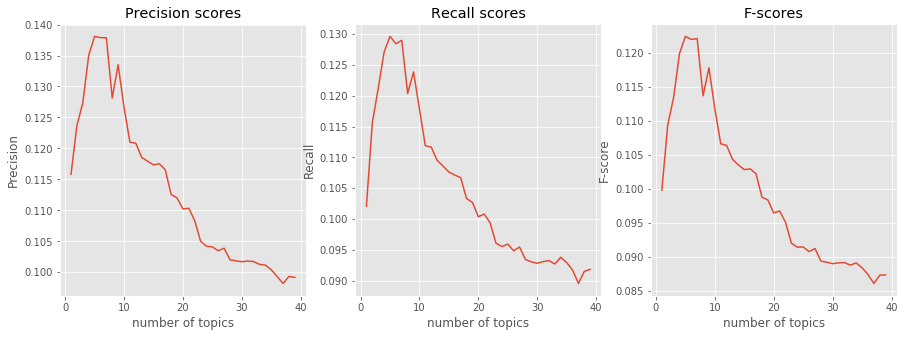

In [102]:
# open CV scores
#cv_scores = pickle.load( open( "models/NMF/NMF_CV.pkl", "rb" ) )

fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))

ax[0].plot(topic_numbers, [cv_scores[item][0] for item in topic_numbers])
ax[0].set_xlabel('number of topics')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision scores')

ax[1].plot(topic_numbers, [cv_scores[item][1] for item in topic_numbers])
ax[1].set_xlabel('number of topics')
ax[1].set_ylabel('Recall')
ax[1].set_title('Recall scores')

ax[2].plot(topic_numbers, [cv_scores[item][2] for item in topic_numbers])
ax[2].set_xlabel('number of topics')
ax[2].set_ylabel('F-score')
ax[2].set_title('F-scores')
plt.show()

F-score is maximized when number of topics is around 5 - 7.  
Let's see some examples of the recommended ingredients

In [107]:
# Factorize matrix with 5 latent variables
model_5 = NMF(n_components = 5)
model_5.fit(V)

# manually inspect some example recommendations
recommend_ing = recommender_NMF(model_5, existing_ing[:5], idx_to_word, word_to_idx, cuisine, 6)

# Show example recommendations 
for i in random.sample(range(len(existing_ing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print(existing_ing[i])
    print("---------- Recommended ingredients ----------")
    print(recommend[i])
    print("---------- Missing ingredients ----------")
    print(missing_ing[i], '\n')


==================== Example 356 ====================
---------- Existing ingredients ----------
['ground_cumin', 'large_garlic_cloves', 'cayenne_pepper', 'carrots', 'yellow_onion']
---------- Recommended ingredients ----------
['onion_powder', 'chopped_cilantro_fresh', 'ground_coriander', 'paprika', 'tomato_paste', 'garlic_powder']
---------- Missing ingredients ----------
['low_sodium_chicken_broth', 'sour_cream', 'ground_coriander', 'extra-virgin_olive_oil', 'mexican', 'black_beans', 'oregano', 'fresh_lime_juice', 'chopped_cilantro_fresh'] 

==================== Example 4154 ====================
---------- Existing ingredients ----------
['light_coconut_milk', 'green_onions', 'sweet_potatoes', 'garlic_chili_sauce', 'fresh_lime_juice']
---------- Recommended ingredients ----------
['beansprouts', 'chopped_cilantro_fresh', 'coconut_milk', 'brown_sugar', 'sesame_oil', 'fish_sauce']
---------- Missing ingredients ----------
['fat_free_less_sodium_chicken_broth', 'lemongrass', 'olive_oil

In [111]:
# some more examples
examples = [['korean','chicken'], 
            ['thai','chicken'],
            ['indian', 'chicken']]

recommend_ing = recommender_NMF(model_5, examples, idx_to_word, word_to_idx, cuisine, 6)

for i in range(len(examples)):
    print("===== EXAMPLE =====")
    print(" Existing ingredients: ", examples[i])
    print(" Recommended ingredients: ", recommend_ing[i], '\n')


===== EXAMPLE =====
 Existing ingredients:  ['korean', 'chicken']
 Recommended ingredients:  ['vegetable_oil', 'sesame_oil', 'garlic', 'sugar', 'soy_sauce', 'water'] 

===== EXAMPLE =====
 Existing ingredients:  ['thai', 'chicken']
 Recommended ingredients:  ['green_onions', 'garlic', 'sesame_oil', 'sugar', 'soy_sauce', 'water'] 

===== EXAMPLE =====
 Existing ingredients:  ['indian', 'chicken']
 Recommended ingredients:  ['carrots', 'tomatoes', 'water', 'pepper', 'garlic', 'onions'] 



<b> The need for a different number of latent variables </b>  
* While the cross-validation evaluation method found the optimal number of topics to be 5, I thought that this number was too low.  
* Our dataset clearly has more than 5 topics. Performing NMF with 5 latent oversimplifies the different types of cuisine we have.  
* For example, the last cell shows the recommended ingredients for three different types of cuisine involving chicken. Note that basically identical ingredients are recommended for both Korean and Thai style cooking.  


### 1(c) ii. Using coherence scores
* We'll select the number of latent variables to be the number of topics that maximizes coherence scores
* For computing the coherence score, we'll use NMF via gensim

In [113]:
# Prepare data for gensim

# Create dictionary
common_dictionary = Dictionary(documents)

# Prepare BOW features for training set
train_text = [documents[idx] for idx in train_idx]
train_corpus = [common_dictionary.doc2bow(text) for text in train_text]  

# Prepare CV set text for computing coherence scores
#cv_text = [documents[idx] for idx in cv_idx]

In [353]:
# compute coherence scores for NMF models of various topic numbers
topic_numbers = list(range(1,100,4))
scores = {}

for k in topic_numbers:
    # train NMF model 
    nmf = Nmf(train_corpus, id2word = common_dictionary, num_topics = k)
   
    # compute coherence on cv
    cm = CoherenceModel(model=nmf, texts=cv_text, window_size = 60, coherence='c_uci')
    coherence = cm.get_coherence() 
    scores[k] = coherence
    
# save
f = open("models/NMF/NMF_coherence.pkl","wb")
pickle.dump(scores,f)
f.close()

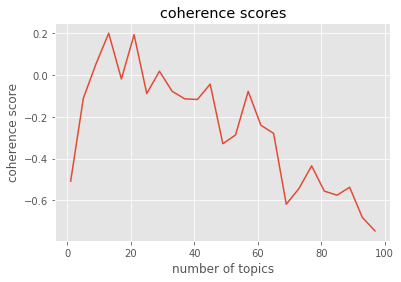

In [354]:
plt.plot(topic_numbers, [scores[item] for item in topic_numbers])
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.title('coherence scores')
plt.show()

Based on the above graph, the number of topics that leads to the highest coherence score is 20.  
For fun, let's take a look at the topics learned by the 20 topics

In [114]:
# load index for train, cv, test
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
train_idx = list(f.get("train_idx"))
cv_idx = list(f.get("cv_idx"))
test_idx = list(f.get("test_idx"))
f.close()

# Prepare BOW features for training set
train_text = [ingredients[idx] for idx in train_idx]
train_corpus = [common_dictionary.doc2bow(text) for text in train_text]  

In [115]:
# train NMF model 
gensim_nmf = Nmf(train_corpus, id2word = common_dictionary, num_topics = 20)

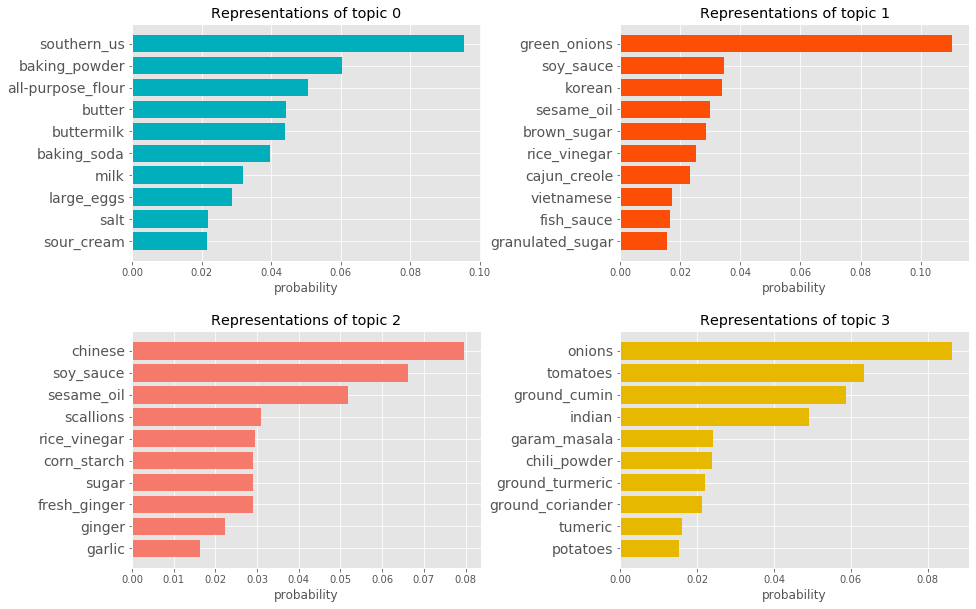

In [481]:
# Visualize topic representations for 4 (out of 20) topics
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
colors = ["#00AFBB", "#FC4E07", "#f57a6c", "#E7B800"]
for i in range(4):
    row = i // 2
    col = i % 2
    
    topic_rep = gensim_nmf.show_topic(i)
    words = [item[0] for item in topic_rep][::-1]
    prob = [item[1] for item in topic_rep][::-1]
    
    ax[row][col].barh(words, prob, color = colors[i])
    ax[row][col].tick_params(axis="y", labelsize=14)
    ax[row][col].set_xlabel('probability')
    ax[row][col].set_title('Representations of topic '+ str(i))
    
fig.subplots_adjust(wspace=0.4, hspace = 0.3)
plt.show()

The above graph shows the top 10 most probable ingredients for 4 of the 20 topics learned by NMF. 
* Topic 1 seems to represent ingredients for baking / southern food  
* Topic 2 seems to represent ingredients for east asian cuisine, excluding Chinese food  
* Topic 3 seems to represent ingredients for Chinese cuisine  
* Topic 4 seems to represent ingredients for Indian cuisine 



## 2(d) Build a recommender

In [117]:
# Find NMF with 20 latent variables
model_20 = NMF(n_components = 20)
model_20.fit(V)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=20, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [118]:
# get recommendations
recommend = recommender_NMF(model_20, existing_ing, idx_to_word, word_to_idx, cuisine, 6)

In [119]:
# Show example recommendations 
for i in random.sample(range(len(existing_ing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print(existing_ing[i])
    print("---------- Recommended ingredients ----------")
    print(recommend[i])
    print("---------- Missing ingredients ----------")
    print(missing_ing[i], '\n')

==================== Example 9015 ====================
---------- Existing ingredients ----------
['salt_and_ground_black_pepper', 'pears', 'prosciutto', 'pizza_crust', 'cornmeal']
---------- Recommended ingredients ----------
['baking_powder', 'vegetable_oil', 'green_onions', 'grated_parmesan_cheese', 'milk', 'eggs']
---------- Missing ingredients ----------
['shredded_swiss_cheese', 'fresh_mozzarella', 'olive_oil', 'italian', 'garlic', 'all-purpose_flour'] 

==================== Example 8033 ====================
---------- Existing ingredients ----------
['saffron', 'chili_oil', 'tomatoes', 'sweet_mustard', 'onions']
---------- Recommended ingredients ----------
['tomato_paste', 'ground_cumin', 'chicken_broth', 'potatoes', 'green_bell_pepper', 'carrots']
---------- Missing ingredients ----------
['indian', 'green_chilies', 'coriander', 'cauliflower', 'extra-virgin_olive_oil', 'garam_masala', 'curry_leaves', 'water', 'garbanzo_beans'] 

==================== Example 487 ===============

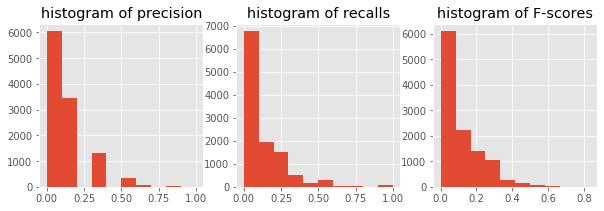

Average precision on cross validation set:  0.111841131729261
Average recall on cross validation set:  0.10258207928402006
Average F-score on cross validation set:  0.0982910401011372


In [122]:
scores = [compute_scores(recommend[i], missing_ing[i]) for i in range(len(missing_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Average precision on cross validation set: ", statistics.mean(precisions) )
print("Average recall on cross validation set: ", statistics.mean(recalls) )
print("Average F-score on cross validation set: ", statistics.mean(Fscores) )

The model doesn't seem to perform very well as a recommendation system. See the following section for ideas for improvement.

## 2(e) Ideas for improvement

1. Selecting the number of latent variables
    * Evaluation on cross-validation resulted in 6 latent variables. The coherence score resulted in 20 latent variables.
    * Note that 20 is still a low number of latent variables. For example, one of the topics (topic 1) represented a mix of various east asian cuisine excluding Chinese cuisine. A recommender based on this model could recommend a mix of ingredients that do not necessarily go well together. 
    * Cross-validation for unsupervised learning models can be difficult. There are some other ways to perform cross-validation on NMF, as illustrated in this <a href="http://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/">blog post</a>.    
2. Tackling bias in dataset.  
    * We can gather more data to create a more diverse dataset.  
3. Sampling based recommender.  
    * In order to add variety to the ingredients recommended, we can build a recommender that sample ingredients according to a probability distribution determined by NMF model. We will need more computing power for this to be feasible. 
    * Try cloud computing.  
4. Differentiating unknown values from 0s.
    * Given a list of ingredients, the list is represented by a row vector of 0s and 1s, where 1 is assigned if the ingredient is present.  
    * While we use the 0s to indicate the fact that it is unknown whether the ingredient should be present or not, sklearn treats 0s as observed absence of an ingredient.   
    * There are ways to perform NMF while differentiating missing / unknown values from 0s. One can write a custom SGD to optimize the cost function only based on the observed ingredients.  
    * While differentiating the unknown values from 0s would be more accurate for our problem, I'm not sure if this will necessarily lead to a better performing recommender.  

# 3. Word embeddings  

<b> Why word embeddings? </b>  
* Word analogy functionalities of word embeddings can be useful in understanding questions like "what vegetable would go well with lamb?". 
* I wanted to build a context-dependent recommender using word embeddings.

<b> Three word embedding models </b>  
I considered three word embedding models for building the recommender:
1. Pretrained Word2Vec embedding  
2. Word2Vec embedding with custom training  
3. Word2Vec neural network with custom training  

Note that Word2Vec embeddings are obtained while training a neural network to perform a supervised learning task. The third model uses the trained neural network itself to build the recommender.  

<b> Summary </b>
* Given a word, the most similar words are sometimes
    * substitutes and similar ingredients
    * complementary ingredients
* For example, given the ingredient "chicken", the closest ingredients may be the following : garlic, onions, chicken stock, chicken broth, chicken breasts, sauce, pepper, .... 
    * While garlic and onions are considered good complementary ingredients, ingredients like chicken stock, chicken broth, chicken breasts similar items that we do not necessarily need. 
* An ingredient recommender will ideally return the complementary ingredients, and not necessarily the substitutes. This may be one of the reasons why a recommender based solely on word embedding might not perform very well.  
* The third model, which uses the neural network itself to recommend ingredients, performs better than the recommender based on word embeddings. This might be because the neural network objective is aligned with the objective of the ingredient recommender.  



<b> Idea behind Continuous-Bag-Of-Words model </b>   
* Word2Vec embeddings are learned while training a neural network to perform a supervised learning task.  
* In this project, I chose the Continuous-Bag-Of-Words (CBOW) model word embedding, which extracts word embeddings while training a neural network that predicts a target word given the context words.  
* Say we are building a CBOW model that takes 4 context words (window size of 2) to predict a target word. 
* Given an example document "lemon zest", "eggs", "vanilla extract", "sour cream", "sugar" "cream cheese", the example text generates the following training data.

Example document | Context | Target |  
--- | --- | --- |
<b>lemon zest</b>, <ins>eggs, vanilla extract</ins>, sour cream, sugar | <ins>eggs, vanilla</ins>| <b>lemon zest</b> | 
*lemon zest*, <b>eggs</b>,*vanilla extract, sour cream*, sugar  | *lemon zest, vanilla extract, sour cream* | <b>eggs</b> |
*lemon zest, eggs,* <b>vanilla extract</b>, *sour cream, sugar* | *lemon zest, eggs, sour cream, sugar*  | <b>vanilla extract</b> |  
lemon zest, *eggs, vanilla extract*, <b>sour cream</b>, *sugar* | *eggs, vanilla extract, sugar* | <b>sour cream</b>| 
lemon zest, eggs, *vanilla extract, sour cream*, <b>sugar</b> | *vanilla extract, sour cream*  | <b>sugar</b>| 

<b> NOTE: context of the CBOW model </b>  
* In the CBOW model, the context consists of words that are in the neighborhood of the target word. 
* However, for the purpose of this project, the context should be a collection of ingredients that belong in the same recipe. The order of ingredients should not matter.  
* In order to take this into account, I performed the following:
    (1) permuted the order of ingredients in each document, or
    (2) make the context to be the entire document (recipe)

In [9]:
# load data
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = list(np.unique(df.cuisine))

# Convert to correct format (list of lists)
documents = [ast.literal_eval(df.document[idx]) for idx in range(df.shape[0])]

# randomly shuffle the order of ingredients in each document
for item in documents:
    random.shuffle(item)
    
# load train, cv, test data index
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
train_idx = list(f.get("train_idx"))
cv_idx = list(f.get("cv_idx"))
test_idx = list(f.get("test_idx"))
f.close()

train_doc = [documents[i] for i in train_idx]
cv_doc = [documents[i] for i in test_idx]

## 3(a) Pretrained Word2Vec model

<b> model </b>
* pre-trained word2vec model from the <a href="https://code.google.com/archive/p/word2vec/">Google News dataset</a>
* The model contains 300-dimensional vectors for 3 million words and phrases  
* You should download the pre-trained model in the <a href="https://code.google.com/archive/p/word2vec/">Google Code Archive</a>

<b> summary </b> 
* The pre-trained model takes a <b>long time to load the model</b>, probably because the model contains 3 million words and phrases. 
* The words are not clean: singular and plural nouns, as well as capitalized and lowercase words, are all embedded as separate vectors.   
* The query results are not fit for ingredients recommendation. When we query with an ingredient & cuisine style, the pre-trained model returns dishes involving the ingredient and cuisine style, but not necessarily the ingredients. 


In [3]:
# load pre-trained word2vec model
tic = time.time()
path_googlenews = 'models/word2vec/GoogleNews-vectors-negative300.bin'
pretrained_word2vec= gensim.models.KeyedVectors.load_word2vec_format(path_googlenews, binary=True) 
toc = time.time()
duration = toc-tic
print('time for loading pre-trained word2vec model: %f seconds' %duration)

time for loading pre-trained word2vec model: 29.680778 seconds


<b> Explore some example word analogies with pre-trained embedding </b>


In [6]:
# What vegetable would go well with lamb?
# steak : asparagus = lamb : ?
pretrained_word2vec.similar_by_vector(pretrained_word2vec['lamb']
                                         + pretrained_word2vec['asparagus'] 
                                         - pretrained_word2vec['steak'],restrict_vocab=None)

[('asparagus', 0.7477847933769226),
 ('lamb', 0.7341278791427612),
 ('leeks', 0.6118133664131165),
 ('pears', 0.5814478993415833),
 ('artichokes', 0.5737591981887817),
 ('Asparagus', 0.570747971534729),
 ('lambs', 0.5622800588607788),
 ('lettuces', 0.5590056777000427),
 ('cauliflower', 0.556602954864502),
 ('grapes', 0.5431725978851318)]

In [7]:
# What ingredients do I need if I want to cook Indian style chicken?
pretrained_word2vec.similar_by_vector(pretrained_word2vec['chicken'] 
                                         + pretrained_word2vec['indian'],topn=15)


[('indian', 0.7856177091598511),
 ('chicken', 0.6813027858734131),
 ('bhindi', 0.5753321051597595),
 ('chinese', 0.5726394653320312),
 ('kheema', 0.5670615434646606),
 ('murgh', 0.5662177801132202),
 ('pata', 0.5563851594924927),
 ('frijoles', 0.5535427331924438),
 ('karahi', 0.5507655143737793),
 ('baingan', 0.5482612252235413),
 ('thosai', 0.5467449426651001),
 ('indians', 0.5445945858955383),
 ('pakoda', 0.5417669415473938),
 ('india', 0.541608452796936),
 ('american', 0.5409203767776489)]

The above word analogies show two problems with using the pretrained word2vec model.     
   1. The words are not very clean. Singular and plural words are embedded as separate words. Similarly, lower case and capitalized words are embedded as separate words.   
   2. When the word2vec model is queried for recommendations on 'Indian style chicken', the model returns a list of Indian dishes that involve chicken. However, it doesn't return the actual ingredients that one would need to create these dishes.


## 3(b) custom-trained Word2Vec model

* A Word2Vec model was trained on the ingredients data

<b> Summary </b>
* The resulting model is <b>fast</b> to train
* The word-analogy results were more fit for our purpose.  
* However, given an ingredient, the similar words were not necessarily complementary ingredients. Sometimes, the similar words were substitutes to the given ingredient.  

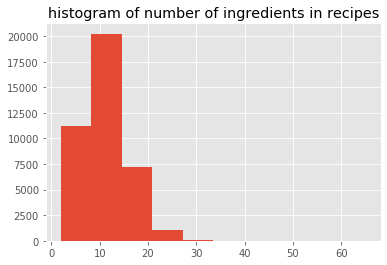

maximum number of ingredients in a given recipe:  65
minimum number of ingredients in a given recipe:  2


In [159]:
# Given a document and an ingredient, use all other ingredients in the same document as context

# Number of ingredients in each recipe
ing_len = [len(x) for x in documents]

plt.hist(ing_len)
plt.title('histogram of number of ingredients in recipes')
plt.show()
print('maximum number of ingredients in a given recipe: ', max(ing_len))  
print('minimum number of ingredients in a given recipe: ', min(ing_len))

In [164]:
# train word2vec
embedding_dim=300
model=gensim.models.Word2Vec(documents, 
                             size=embedding_dim, 
                             window=33, 
                             min_count=0, 
                             iter = 10)

In [165]:
# what ingredients are most similar to a given ingredient?
word = 'chicken'

word_sim = model.wv.most_similar(word, topn = 15)
print("Ingredients that are most similar to "+ str(word))
print(*word_sim, sep='\n')

Ingredients that are most similar to chicken
('chicken_breasts', 0.7559722065925598)
('chicken_thighs', 0.7339152097702026)
('boneless_chicken_breast', 0.6779407262802124)
('boneless_skinless_chicken_breasts', 0.64495849609375)
('chicken_pieces', 0.6433842182159424)
('chicken_legs', 0.5989812612533569)
('meat', 0.5918811559677124)
('chicken_meat', 0.5782774686813354)
('skinless_chicken_breasts', 0.5696227550506592)
('boneless_chicken_skinless_thigh', 0.5435144305229187)
('lamb_chops', 0.5178095102310181)
('bay_leaves', 0.5152599215507507)
('pork_butt', 0.5108005404472351)
('boneless_skinless_chicken', 0.5052850246429443)
('chuck_roast', 0.5030993223190308)


<b> Note </b>
* One can vary many of the parameters involved with training Word2Vec.  
* I chose a window size of 33 so that every ingredient in a document can be considered as context.  
* The number of iterations also makes a visible difference. Word2Vec models trained with high number of iterations will embed ingredients so that similar ingredients (substitutes) will be embedded as similar vectors. 

<b> Word analogies </b> 
* Let's say I'm cooking lamb, and I want to know what vegetable would go well with lamb. 
* I can use known protein-vegetable pairings, such as steak & asparagus, to ask the word embedding to solve the following word analogy problem  
    <b>steak</b> is to <b>asparagus</b> as <b>lamb</b> is to <b>?</b>   
    i.e., steak : asparagus = lamb : ?  
* That is, we want to find the ingredient that best satisfies the following:  
    wv['asparagus']-wv['steak'] = wv[?] - wv['lamb'], or
    wv[?] = wv['lamb'] + wv['asparagus'] - wv['steak']
    

In [79]:
model.wv.similar_by_vector(model.wv['lamb']+model.wv['asparagus']-model.wv['steak'],restrict_vocab=None)

[('asparagus', 0.8026875257492065),
 ('florets', 0.7683296203613281),
 ('yellow_crookneck_squash', 0.7330018281936646),
 ('harissa_paste', 0.6923336982727051),
 ('fennel_bulb', 0.6366307735443115),
 ('brine_cured_green_olives', 0.6307729482650757),
 ('fronds', 0.6216326951980591),
 ('pinenuts', 0.620043158531189),
 ('spinach_leaves', 0.619823694229126),
 ('artichokes', 0.6192194223403931)]

<b> Cooking in style </b>  
* What if I wanted to cook a particular ingredient in a particular cuisine?  
* For example, if I wished to cook chicken in an Indian style cuisine, what other ingredients would go well?

In [80]:
model.wv.similar_by_vector(model.wv['chicken'] + model.wv['indian'],topn=15)

[('indian', 0.9408016204833984),
 ('garam_masala', 0.6604063510894775),
 ('powdered_turmeric', 0.6591247916221619),
 ('yoghurt', 0.652044415473938),
 ('basmati_rice', 0.6508928537368774),
 ('plain_yogurt', 0.6484106779098511),
 ('natural_yogurt', 0.6417350769042969),
 ('ground_turmeric', 0.6345005035400391),
 ('whole_milk_yoghurt', 0.6327574253082275),
 ('fenugreek', 0.6308575868606567),
 ('tumeric', 0.6234149932861328),
 ('green_cardamom_pods', 0.6210233569145203),
 ('curry_leaves', 0.614196240901947),
 ('bengali_5_spice', 0.606643795967102),
 ('black_mustard_seeds', 0.6029819250106812)]

<b>Recommending new ingredients from existing ingredients </b>  
* For example, let's say I want to cook my chicken in Korean style, and I have the following ingredients: chicken, onions, sesame seeds.  
* Can the model recommend some other ingredients that would go well?  

In [81]:
model.wv.similar_by_vector(model.wv['chicken'] + model.wv['korean']
                           + model.wv['onions'] + model.wv['sesame_seeds'],topn=15)

[('korean', 0.8160548806190491),
 ('rice_wine', 0.6937564015388489),
 ('gochujang_base', 0.6881811618804932),
 ('sandwich_steak', 0.6599498987197876),
 ('cress', 0.6517894268035889),
 ('sesame_seeds', 0.639244794845581),
 ('peapods', 0.6373145580291748),
 ('soy_bean_paste', 0.6156319975852966),
 ('hot_bean_paste', 0.6145368814468384),
 ('gochugaru', 0.6096622943878174),
 ('kimchi', 0.6007468104362488),
 ('brown_rice_vinegar', 0.5979486703872681),
 ('fried_eggs', 0.5929040908813477),
 ('toasted_sesame_seeds', 0.5797392129898071),
 ('sesame_chili_oil', 0.5733048915863037)]

### Build a recommender
* Train word2vec only on the training set
* Evaluate performance of recommender on training set and CV set

In [137]:
# train word2vec
embedding_dim=300
model=gensim.models.Word2Vec(train_doc, 
                             size=embedding_dim, 
                             window=5, 
                             min_count=0, 
                             iter = 10)

In [138]:
def recommend_word2vec(model, existing_ing, cuisine, n):
    # Recommend ingredients using Word2Vec embedding.  
    # Given a list of existing ingredients, find the vector "v" representing the existing ingredients
    # Recommend ingredients that are similar to this vector "v"
    
    # model: trained Word2Vec model
    # existing_ing: (list of lists) Each item is a list of existing ingredients for a particular recipe 
    # cuisine: (list) of cuisine names 
    # recommend: (list of lists) Each item is a list of recommended ingredients
    
    recommend = []

    for idx, document in enumerate(existing_ing):
        
        # turn existing ingredients into a word vector
        # sum the vectors for all ingredients, only if the ingredient exists in the model
        vec = sum([model.wv[item] for item in document if item in model.wv.vocab])
        
        # find similar ingredients
        similar_ing = model.wv.similar_by_vector(vec,topn = n + len(document) + len(cuisine))
        
        # remove existing ingredients and cuisine names
        rec_ing = [item[0] for item in similar_ing if item[0] not in document
                  and item[0] not in cuisine]
        recommend.append(rec_ing[:n])
    return recommend

<b> Make ingredient recommendations for training data </b> 


In [142]:
# get existing ingredients and the remaining ingredients to be predicted
existing_ing, missing_ing = sample_ingredients(train_doc, 5)

# predict remaining ingredients
recommend = recommend_word2vec(model, existing_ing, cuisine, 6)

In [143]:
# Show example recommendations 
for i in random.sample(range(len(existing_ing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print(existing_ing[i])
    print("---------- Recommended ingredients ----------")
    print(recommend[i])
    print("---------- Missing ingredients ----------")
    print(missing_ing[i], '\n')

==================== Example 18565 ====================
---------- Existing ingredients ----------
['parmigiano_reggiano_cheese', 'onions', 'italian', 'freshly_ground_pepper', 'extra-virgin_olive_oil']
---------- Recommended ingredients ----------
['freshly_grated_parmesan', 'pecorino_romano_cheese', 'portabello_mushroom', 'italian_plum_tomatoes', 'pecorino_cheese', 'fresh_parsley_leaves']
---------- Missing ingredients ----------
['beans', 'thyme', 'white_wine', 'pearl_barley', 'unsalted_butter', 'escarole', 'vegetable_stock'] 

==================== Example 16816 ====================
---------- Existing ingredients ----------
['yukon_gold_potatoes', 'fennel', 'sea_salt', 'water', 'chicken_thighs']
---------- Recommended ingredients ----------
['coarse_sea_salt', 'spanish_chorizo', 'fish_fillets', 'turnips', 'lamb_shanks', 'veal_knuckle']
---------- Missing ingredients ----------
['freshly_ground_pepper', 'french', 'tomatoes', 'extra-virgin_olive_oil'] 

==================== Example 47

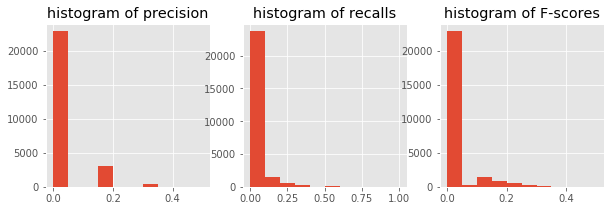

Average precision on cross validation set:  0.024147221798586752
Average recall on cross validation set:  0.022873992227487677
Average F-score on cross validation set:  0.02132875529404803


In [144]:
scores = [compute_scores(recommend[i], missing_ing[i]) for i in range(len(missing_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Average precision on cross validation set: ", statistics.mean(precisions) )
print("Average recall on cross validation set: ", statistics.mean(recalls) )
print("Average F-score on cross validation set: ", statistics.mean(Fscores) )

<b> Make ingredient recommendations for CV set </b>

In [118]:
# get existing ingredients and the remaining ingredients to be predicted
existing_ing, missing_ing = sample_ingredients(cv_doc, 5)

# predict remaining ingredients
recommend = recommend_word2vec(model, existing_ing, cuisine, 6)

In [ ]:
# Show example recommendations 
for i in random.sample(range(len(existing_ing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print(existing_ing[i])
    print("---------- Recommended ingredients ----------")
    print(recommend[i])
    print("---------- Missing ingredients ----------")
    print(missing_ing[i], '\n')

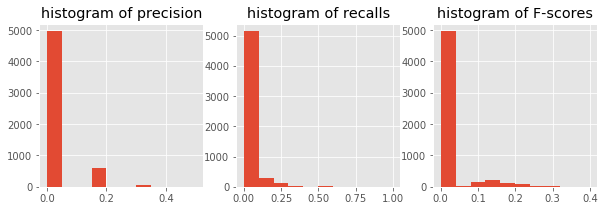

Average precision on cross validation set:  0.021755883573418695
Average recall on cross validation set:  0.019712194929087427
Average F-score on cross validation set:  0.01884710582109211


In [119]:
scores = [compute_scores(recommend[i], missing_ing[i]) for i in range(len(missing_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Average precision on cross validation set: ", statistics.mean(precisions) )
print("Average recall on cross validation set: ", statistics.mean(recalls) )
print("Average F-score on cross validation set: ", statistics.mean(Fscores) )

<b> Summary </b> 
* Ingredient recommender based on similarites of word embeddings does not perform very well.  
* I think this is because word embeddings assign similar vectors to similar (substitute) ingredients. 
* We want the ingredient recommender to recommend complementary ingredients instead of substitutes. 

## 3(c) Neural network from Word2Vec

* Note that the Word2Vec model is trained through a neural network that performs the task of predicting a target word from its context.  
* I will use the neural network itself to build the recommender. 
* I believe this recommender will perform decently since the neural network objective is aligned with the objective of the recommender

In [130]:
def recommend_word2vec_NN(model, existing_ing, cuisine, n):
    # Recommend ingredients using the neural network of the trained Word2Vec model.
    # Given a list of existing ingredients, return ingredients that have the highest 
    # probabilities according to the underlying neural network.
    
    # model: trained Word2Vec model
    # existing_ing: (list of lists) Each item is a list of existing ingredients for a particular recipe 
    # cuisine: (list) of cuisine names
    # n: (int) number of ingredients to recommend
    
    recommend = []

    for idx, doc in enumerate(existing_ing):

        # recommend ingredients
        prediction = model.predict_output_word(doc, topn = n + len(existing_ing) + len(cuisine))
        prediction = [item[0] for item in prediction if (item[0] not in doc
                                                    and item[0] not in cuisine)]
        recommend.append(prediction[:n])
        
    return recommend

In [121]:
# load train, cv, test data index
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
train_idx = list(f.get("train_idx"))
cv_idx = list(f.get("cv_idx"))
test_idx = list(f.get("test_idx"))
f.close()

train_doc = [documents[i] for i in train_idx]
cv_doc = [documents[i] for i in test_idx]

In [152]:
# train model
model = Word2Vec(train_doc, window = 33, compute_loss = True, iter = 10)
# while the model computes the loss, its a cumulative loss
# (not the loss from the most recent epoch)

<b> Make ingredient recommendations for training data </b> 


In [153]:
# get existing ingredients and the remaining ingredients to be predicted
existing_ing, missing_ing = sample_ingredients(train_doc, 5)

# predict remaining ingredients
recommend = recommend_word2vec_NN(model, existing_ing, cuisine, 6)

In [154]:
# Show example recommendations 
for i in random.sample(range(len(existing_ing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print(existing_ing[i])
    print("---------- Recommended ingredients ----------")
    print(recommend[i])
    print("---------- Missing ingredients ----------")
    print(missing_ing[i], '\n')

==================== Example 18924 ====================
---------- Existing ingredients ----------
['feta_cheese', 'salsa', 'tortillas', 'mexican', 'eggs']
---------- Recommended ingredients ----------
['shredded_cheese', 'flour_tortillas', 'black_olives', 'lettuce', 'avocado', 'refried_beans']
---------- Missing ingredients ----------
['avocado', 'refried_beans'] 

==================== Example 25597 ====================
---------- Existing ingredients ----------
['chickpeas', 'lemon', 'butter', 'noodles', 'eggs']
---------- Recommended ingredients ----------
['bread_crumbs', 'parsley', 'flour', 'lamb', 'spinach', 'saffron']
---------- Missing ingredients ----------
['canned_tomatoes', 'fresh_cilantro', 'black_pepper', 'celery', 'lentils', 'cinnamon', 'tumeric', 'onions', 'fresh_parsley', 'moroccan', 'ginger', 'lamb'] 

==================== Example 3685 ====================
---------- Existing ingredients ----------
['tumeric', 'chopped_cilantro', 'eggs', 'golden_raisins', 'leg_of_lamb

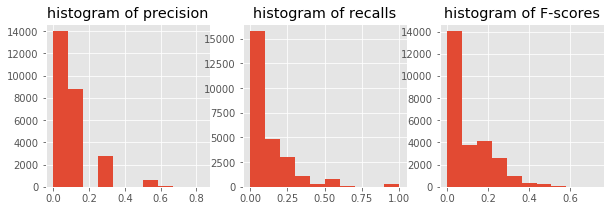

Average precision on cross validation set:  0.10444308881093996
Average recall on cross validation set:  0.10522471243622446
Average F-score on cross validation set:  0.09475098836719886


In [155]:
scores = [compute_scores(recommend[i], missing_ing[i]) for i in range(len(missing_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Average precision on cross validation set: ", statistics.mean(precisions) )
print("Average recall on cross validation set: ", statistics.mean(recalls) )
print("Average F-score on cross validation set: ", statistics.mean(Fscores) )

<b> Make ingredient recommendations for CV set </b>

In [156]:
# get existing ingredients and the remaining ingredients to be predicted
existing_ing, missing_ing = sample_ingredients(cv_doc, 5)

# predict remaining ingredients
recommend = recommend_word2vec_NN(model, existing_ing, cuisine, 6)

In [157]:
# Show example recommendations 
for i in random.sample(range(len(existing_ing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print(existing_ing[i])
    print("---------- Recommended ingredients ----------")
    print(recommend[i])
    print("---------- Missing ingredients ----------")
    print(missing_ing[i], '\n')

==================== Example 465 ====================
---------- Existing ingredients ----------
['chili_powder', 'tomatoes', 'indian', 'roasted_peanuts', 'ginger']
---------- Recommended ingredients ----------
['coriander', 'cilantro_leaves', 'cumin_seed', 'cilantro', 'fresh_coriander', 'ground_cumin']
---------- Missing ingredients ----------
['grated_coconut', 'finely_chopped_onion', 'green_chilies', 'tumeric', 'roasted_sesame_seeds', 'ghee', 'pepper', 'garlic', 'coconut_milk', 'broccoli'] 

==================== Example 1025 ====================
---------- Existing ingredients ----------
['purple_onion', 'water', 'french', 'freshly_ground_pepper', 'fresh_dill']
---------- Recommended ingredients ----------
['red_wine_vinegar', 'fresh_lemon_juice', 'sherry_vinegar', 'dijon_mustard', 'white_wine_vinegar', 'baguette']
---------- Missing ingredients ----------
['fresh_lemon_juice', 'prepared_horseradish', 'fat_free_cream_cheese', 'pink_salmon'] 

==================== Example 3702 ======

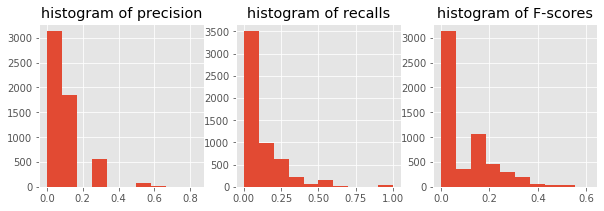

Average precision on cross validation set:  0.09641946766257632
Average recall on cross validation set:  0.09776173096493276
Average F-score on cross validation set:  0.08823825470838398


In [158]:
scores = [compute_scores(recommend[i], missing_ing[i]) for i in range(len(missing_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Average precision on cross validation set: ", statistics.mean(precisions) )
print("Average recall on cross validation set: ", statistics.mean(recalls) )
print("Average F-score on cross validation set: ", statistics.mean(Fscores) )

<b> Summary </b> 
* The recommender built on the underlying neural network of Word2Vec seems to perform decently.  
* One can work on improving the recommender by exploring various structures of neural networks. 

# 4. Association rule mining

* Association rule mining is a tool used in market basket analysis that seeks relationships between purchases.  
* It finds rules of the form X => Y, which represents "X implies Y"
* For example, the rule {onions, potatoes} => {burger} found in the sales data would indicate that if a customer buys both onions and potatoes, then they are also likely to buy hamburger meat.  
* In this project, I used association rule mining to learn relationships among ingredients. For example, the rule {chicken, korean} => {seasame oil} would imply that if a recipe involves chicken and korean cuisine, then it is likely to also involve seasame oil as its ingredient. 
* Used Apriori algorithm to learn the rules.

## 4.1 Implement the apriori algorithm

* The apriori algorithm learns all rules of form X => Y where
    * X, Y are collections of items, called itemset.  
    * X and Y are itemsets with frequency (support) greater than min_support
    * The strength of the implication X => Y (as measured by confidence) is stronger than min_confidence  
* Apriori algorithm requires the user to specify minimum support of itemsets to consider and minimum confidence of the rules. 
* In this section, I played around with different minimum support and minimum confidence values and learned the rules among ingredients using the apriori algorithm.

In [305]:
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = np.unique(df.cuisine)

# note: ing_cuisine is now a string representation of list
# need to convert back to list
ingredients = [ast.literal_eval(df.ing_cuisine[idx]) for idx in range(df.shape[0])]

# change data format to list of tuples for apriori algorithm 
ing_list = [tuple(item) for item in ingredients]

In [306]:
# get the list of ingredients
ingredients_total = [item for sublist in ing_list for item in sublist]

# count occurrence of ingredients
ing_count = Counter(ingredients_total)

# sort ingredients in order of decreasing frequency 
ing_by_count = [k for k, v in sorted(ing_count.items(), key = lambda item:item[1])]
ing_by_count.reverse()

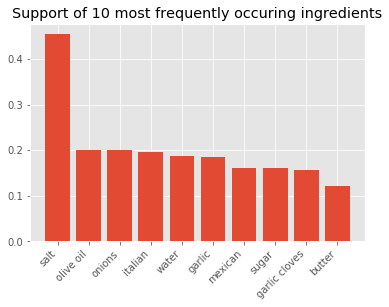

In [307]:
#plot the support of 10 most frequently occurring ingredients
plt.bar(ing_by_count[:10], [ing_count[item]/len(ing_list) for item in ing_by_count[:10]])
plt.xticks(list(range(10)), ing_by_count[:10], ha = 'right', rotation=45)
plt.title('Support of 10 most frequently occuring ingredients')
plt.show()

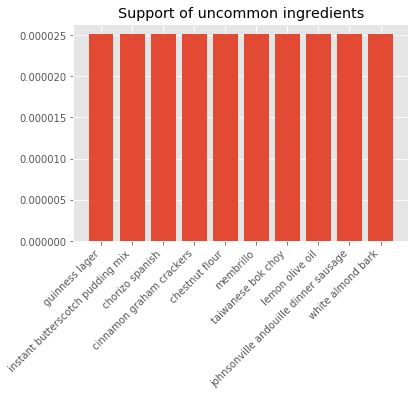

In [308]:
# plot the 10 most rarely occurring ingredients
# use support, instead of frequency 
plt.bar(ing_by_count[-10:], [ing_count[item]/len(ing_list) for item in ing_by_count[-10:]])
plt.xticks(list(range(10)), ing_by_count[-10:], ha = 'right', rotation=45)
plt.title('Support of uncommon ingredients')
plt.show()

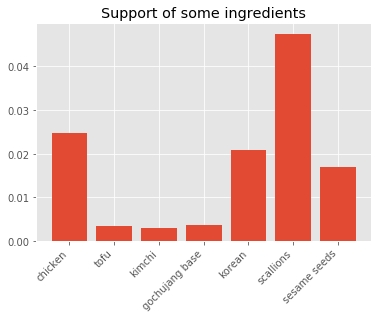

In [309]:
# support of ingredients that I think should be included
my_ingredients = ['chicken','tofu','kimchi', 'gochujang base', 'korean', 'scallions', 'sesame seeds']
plt.bar(my_ingredients, [ing_count[item]/len(ing_list) for item in my_ingredients])
plt.xticks(list(range(len(my_ingredients))), my_ingredients, ha = 'right', rotation=45)
plt.title('Support of some ingredients')
plt.show()

In [310]:
# what are some ingredients with a given support value?
support = 0.001
freq = support * len(ing_list)
ingredients_support = [item for item in ing_by_count if ing_count[item] <= freq + 10 and ing_count[item] >= freq -10 ]
print(ingredients_support[:20])

['organic vegetable broth', 'salad greens', 'file powder', 'rocket leaves', 'ground round', 'cod fillets', 'colby jack cheese', 'pitted date', 'tapioca flour', 'frozen spinach', 'green bell pepper, slice', 'plain whole-milk yogurt', 'duck', 'softened butter', 'low-fat plain yogurt', 'dried tarragon leaves', 'cooked turkey', 'alfredo sauce', 'brewed coffee', 'hot italian sausages']


In [311]:
# LEARNING THE RULES

itemsets, rules = apriori(ing_list, min_support=0.001, min_confidence=0.3)
with open("models/association_rule_mining/rules.txt", "wb") as fp:
    pickle.dump(rules, fp)

## 4.2 Query the rules 

In [312]:
# load the learned rules
with open("models/association_rule_mining/rules.txt", "rb") as fp:
    rules = pickle.load(fp)
    
print('number of rules learned: ', len(rules))

number of rules learned:  74470


In [313]:
def get_rules(rules, query):
    # Find all rules of the form "query" => ?

    # query must have the format ('ingredient1', ) or ('ingredient1','ingredient2', ... ,)
    # note that some rules will have multiple items in the right hand side. For simplicity, lets just
    # use rules that return one value 
    query_rules = [item for item in rules if set(item.lhs) == set(query)]

    # sorted ccording to decreasing lift values 
    query_rules = sorted(query_rules, key=lambda rule: rule.lift, reverse = True)
    return query_rules   

In [315]:
query = ('gochujang base',)
query_rules = get_rules(rules, query)
for item in query_rules:
    print(item)

{gochujang base} -> {korean, onions} (conf: 0.338, supp: 0.001, lift: 64.638, conv: 1.503)
{gochujang base} -> {korean, soy sauce} (conf: 0.556, supp: 0.002, lift: 51.822, conv: 2.230)
{gochujang base} -> {korean, sesame oil} (conf: 0.521, supp: 0.002, lift: 51.432, conv: 2.067)
{gochujang base} -> {garlic, korean} (conf: 0.373, supp: 0.001, lift: 48.994, conv: 1.583)
{gochujang base} -> {korean, sesame oil, soy sauce} (conf: 0.345, supp: 0.001, lift: 48.670, conv: 1.516)
{gochujang base} -> {green onions, korean} (conf: 0.352, supp: 0.001, lift: 47.798, conv: 1.532)
{gochujang base} -> {korean} (conf: 0.958, supp: 0.003, lift: 45.896, conv: 23.173)
{gochujang base} -> {sesame oil, soy sauce} (conf: 0.366, supp: 0.001, lift: 12.981, conv: 1.533)
{gochujang base} -> {sesame oil} (conf: 0.542, supp: 0.002, lift: 12.164, conv: 2.087)
{gochujang base} -> {soy sauce} (conf: 0.592, supp: 0.002, lift: 7.138, conv: 2.245)
{gochujang base} -> {green onions} (conf: 0.352, supp: 0.001, lift: 4.55

In [316]:
query = ('chicken','soy sauce')
query_rules = get_rules(rules, query)
for item in query_rules:
    print(item)

{chicken, soy sauce} -> {chinese} (conf: 0.372, supp: 0.001, lift: 5.534, conv: 1.485)
{chicken, soy sauce} -> {garlic} (conf: 0.405, supp: 0.001, lift: 2.182, conv: 1.369)
{chicken, soy sauce} -> {water} (conf: 0.331, supp: 0.001, lift: 1.763, conv: 1.214)
{chicken, soy sauce} -> {salt} (conf: 0.479, supp: 0.001, lift: 1.056, conv: 1.049)


## 4.3 Build a recommendation system

* Input a list of existing ingredients.  
* Recommender searches the learned rules to recommend ingredients, starting with the ingredient with highest lift.  
* If the input list of existing ingredient doesn't exist as an itemset in the learned rules (this happens if the given input does not have enough support in the training dataset), then look for the largest subset of the existing ingredients that do exist as an itemset in the rules. Recommend from this largest subset. 

In [317]:
def get_rules(rules, query, lift_threshold = 1):
    # Find all implication rules of the form "query" => RHS
    # such that (i) RHS is a single ingredient and 
    #           (ii) lift value is greater than lift_threshold

    # "query" format ('ingredient1', ) or ('ingredient1','ingredient2', ... ,)
    query = tuple(query)    
    
    # get all rules "query" => RHS satisfying the conditions above
    query_rules = [item for item in rules if set(item.lhs) == set(query) 
                   if item.lift > lift_threshold and len(item.rhs) == 1]

    # sort rules according to decreasing lift values 
    query_rules = sorted(query_rules, key=lambda rule: rule.lift, reverse = True)
    return query_rules   

def recommend(list_ing, list_old, cuisine, rules):  
    # Recommend ingredients to given list of ingredients.
    # Given a list, attempt to find the largest subset of "n" elements such that
    # the subset leads to a valid ingredient recommendataion. 
    # If such "n" is found, then try recommending ingredients 
    # for all "n"-element subset of list_ing
    
    """
    list_ing: current list of ingredients 
    list_old: List of ingredients (a subset of list_ing) that have previously
            been used to ask for ingredient recommentations. 
            For first round of recommendations, list_old = []
            We keep track of "list_old" so that we don't make duplicate
            recommendations.
    rules: rules learned from apriori algorithm
    """           

    rules_lhs = {item.lhs for item in rules}
    n = len(list_ing)
    current_list = list_ing.copy()
    new_ing = []

    itemset_found = False
    
    while itemset_found == False and n > 0:
        # find all itemsets of size n
        comb = combinations(list_ing, n)

        # check if any itemset of size n satifies the conditions
        # (i) itemset isnt' a subset of list_old  
        # (ii) itemset exists as a left hand side element in rules 
        for itemset in comb:
            if (set(itemset).issubset(set(list_old)) == False) and (itemset in rules_lhs):
 
                # check if the itemset leads to a new ingredient recommendation
                query_rules = get_rules(rules, itemset)
                recommendation = [item.rhs[0] for item in query_rules]
                for ing in recommendation:
                    # if there exists an ingredient that is new and is not a cuisine type
                    # then this itemset just contributed a valid recommendation
                    if (ing not in current_list) and (ing not in cuisine):
                        current_list.append(ing)
                        new_ing.append(ing)            
                        itemset_found = True

        n = n-1           
    return new_ing

def make_recommendations(list_ing, cuisine, rules):
    # Make recommendations by calling the function "recommend" repeatedly.
    # Stop making recommendations when there are a total of 15 ingredients 
    # or when the "recommend" function no longer suggests any recommendations
    # whichever comes first.

    list_old = []
    while len(list_ing) <= 15:
        new_ing = recommend(list_ing, list_old, cuisine, rules)
        list_old = list_ing.copy()
        list_ing += new_ing
        if new_ing == []:
            break
            
    return list_ing

In [318]:
# load the learned rules
with open("models/association_rule_mining/rules.txt", "rb") as fp:
    rules = pickle.load(fp)
    
print('number of rules learned: ', len(rules))

number of rules learned:  74470


In [323]:
# ask the recommender for ingredients!
list_ing = ['pork', 'korean']
rules_lhs = {item.lhs for item in rules}
make_recommendations(list_ing, cuisine, rules)

['pork',
 'korean',
 'soy sauce',
 'garlic',
 'onions',
 'salt',
 'sesame oil',
 'green onions',
 'sugar',
 'pepper',
 'olive oil',
 'water',
 'oil']

In [40]:
ing_dictionary = Dictionary(ingredients)
corpus = [ing_dictionary.doc2bow(item) for item in ingredients]

# 5. Future directions / To Do

* Other models to consider  
    * max entropy model  
    
* To do for building recommender system  
    * Use evaluation metric to find the best model 
    * Or, combine the models using ensemble learning techniques  
    * Try using cloud computing
    * Create the app  
    * Use Docker containment for production  
    